In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader



class CorrelatedDataset(Dataset):
    def __init__(self, n_samples=1000, n_features=10, n_groups=2, noise_std=0.1):
        super(CorrelatedDataset, self).__init__()
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_groups = n_groups
        
        self.true_weights = torch.randn(n_features, 1)
        self.features = torch.randn(n_samples, n_features)
        
        features_per_group = n_features // n_groups
        for i in range(n_groups):
            start_idx = i * features_per_group
            end_idx = start_idx + features_per_group
            self.features[:, start_idx:end_idx] = 0.7 * self.features[:, start_idx].unsqueeze(1) + 0.3 * torch.randn(n_samples, features_per_group)
        
        self.targets = self.features @ self.true_weights + noise_std * torch.randn(n_samples, 1)
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

    
    
class LinearRegression(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return self.linear(x)


def l1_regularization(weights, alpha):
    return alpha * torch.norm(weights, 1)

def l2_regularization(weights, alpha):
    return alpha * torch.norm(weights, 2) ** 2



class LassoLoss(nn.Module):
    def __init__(self, alpha):
        super(LassoLoss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, predictions, targets, model_weights):
        loss = self.mse_loss(predictions, targets)
        l1_term = l1_regularization(model_weights, self.alpha)
        return loss + l1_term

class ElasticNetLoss(nn.Module):
    def __init__(self, alpha, rho=0.5):
        super(ElasticNetLoss, self).__init__()
        self.alpha = alpha
        self.rho = rho
        self.mse_loss = nn.MSELoss()

    def forward(self, predictions, targets, model_weights):
        loss = self.mse_loss(predictions, targets)
        l1_term = l1_regularization(model_weights, self.alpha * self.rho)
        l2_term = l2_regularization(model_weights, self.alpha * (1 - self.rho) / 2)
        return loss + l1_term + l2_term

In [2]:
n_features = 10

alpha = 0.5
rho = 0.3

epochs = 100
lr = 0.01



data = CorrelatedDataset()
loader = DataLoader(data, batch_size=32, shuffle=True)

lasso_network = LinearRegression(input_dim=10)
elastic_net_network = LinearRegression(input_dim=10)

lasso_loss_fn = LassoLoss(alpha=alpha)
elastic_net_loss_fn = ElasticNetLoss(alpha=alpha, rho=rho)

lasso_weights = []
elastic_net_weights = []
lasso_losses = []
elastic_net_losses = []

optimizer_lasso = optim.SGD(lasso_network.parameters(), lr=lr)
optimizer_elastic_net = optim.SGD(elastic_net_network.parameters(), lr=lr)

In [3]:
for _ in range(epochs):
    for X, y in loader:
        predictions = lasso_network(X)
        loss_v = lasso_loss_fn(predictions, y, lasso_network.linear.weight)

        optimizer_lasso.zero_grad()
        loss_v.backward()
        optimizer_lasso.step()
        
    lasso_losses.append(loss_v.item())
    lasso_weights.append(lasso_network.linear.weight.detach().clone())

In [4]:
for epoch in range(epochs):
    for X, y in loader:
        predictions = elastic_net_network(X)
        loss_v = elastic_net_loss_fn(predictions, y, elastic_net_network.linear.weight)

        optimizer_elastic_net.zero_grad()
        loss_v.backward()
        optimizer_elastic_net.step()
        
    elastic_net_losses.append(loss_v.item())
    elastic_net_weights.append(elastic_net_network.linear.weight.detach().clone())

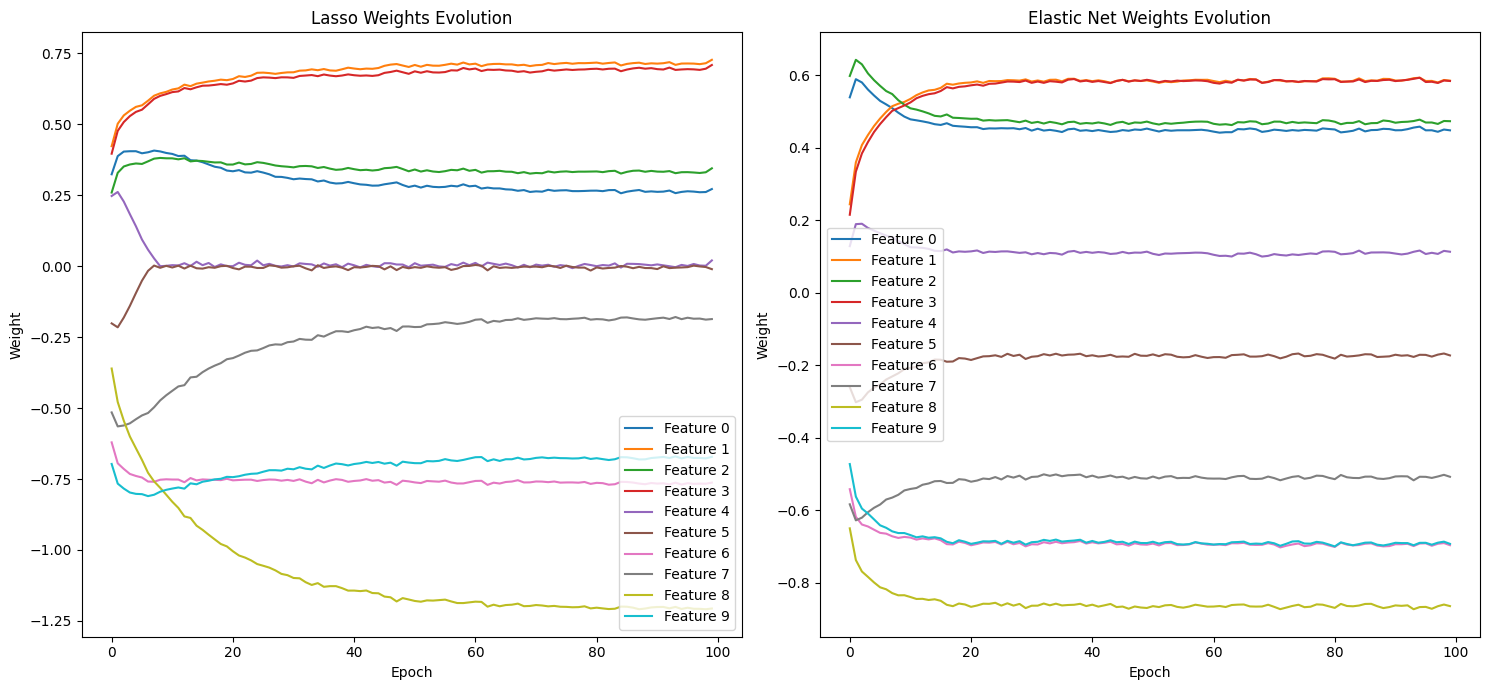

In [5]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
for i in range(n_features):
    plt.plot([w[0, i] for w in lasso_weights], label=f'Feature {i}')
plt.title('Lasso Weights Evolution')
plt.xlabel('Epoch')
plt.ylabel('Weight')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(n_features):
    plt.plot([w[0, i] for w in elastic_net_weights], label=f'Feature {i}')
plt.title('Elastic Net Weights Evolution')
plt.xlabel('Epoch')
plt.ylabel('Weight')
plt.legend()

plt.tight_layout()
plt.show()